In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
import numba
import coffea.hist as hist

In [2]:
#infile = "data/signal/wza_UL18.root" # --signal
infile='data/data/7B56E217-555E-1C41-9494-491849A9835F_skim_2ElIdPt20.root' # --data 
#infile = 'data/data/CA42F3A2-614F-4A4F-AF18-F6E66CDA2C85_skim_2ElIdPt20.root'
#infile = 'data/Ntuple/EGamma_Run2018B.root'
#infile="data/mc/59AB328B-F0E3-F544-98BB-E5E55577C649_skim_2ElIdPt20.root" # --mc


year='2018'

In [3]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [4]:
# Trigger set
doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}



singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
        '2016': [
            'Ele27_WPTight_Gsf',
            'Ele105_CaloIdVT_GsfTrkIdT'
        ],
        '2017': [
            'Ele35_WPTight_Gsf',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Photon200'
        ],
        '2018': [
            'Ele32_WPTight_Gsf',    # Recomended
        ]
    }

In [5]:
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

def TLorentz_vector(vec):
    vec = ak.zip(
    {
                "x":vec.x,
                "y":vec.y,
                "z":vec.z,
                "t":vec.t
    },
    with_name = "LorentzVector"
    )
    return vec

def TLorentz_vector_cylinder(vec):

    vec = ak.zip(
    {
         "pt": vec.pt,
         "eta": vec.eta,
         "phi": vec.phi,
         "mass": vec.mass,
    },
    with_name="PtEtaPhiMLorentzVector",
    )

    return vec


# << Sort by PT  helper function >>
def sort_by_pt(ele,pho,jet):
    ele = ele[ak.argsort(ele.pt,ascending=False,axis=1)]
    pho = pho[ak.argsort(pho.pt,ascending=False,axis=1)]
    jet = jet[ak.argsort(jet.pt,ascending=False,axis=1)]

    return ele,pho,jet

In [6]:
@numba.njit ## Numba compile -- Boost!
def PhotonVID(vid, idBit):
    rBit = 0
    for x in range(0, 7):
        rBit |= (1 << x) if ((vid >> (x * 2)) & 0b11 >= idBit) else 0
    return rBit


@numba.njit ## Numba compile -- Boost!
def make_fake_obj_mask(Pho,builder):

    #for eventIdx,pho in enumerate(tqdm(Pho)):   # --Event Loop
    for eventIdx,pho in enumerate(Pho):
        builder.begin_list()
        if len(pho) < 1: continue;
    
            
        for phoIdx,_ in enumerate(pho):# --Photon Loop
        
            vid = Pho[eventIdx][phoIdx].vidNestedWPBitmap
            vid_cuts1 = PhotonVID(vid,1) # Loose photon
            vid_cuts2 = PhotonVID(vid,2) # Medium photon
            vid_cuts3 = PhotonVID(vid,3) # Tight photon

            # Field name
            # |0|0|0|0|0|0|0| 
            # |IsoPho|IsoNeu|IsoChg|Sieie|hoe|scEta|PT|

            # 1. Turn off cut (ex turn off Sieie
            # |1|1|1|0|1|1|1| = |1|1|1|0|1|1|1|

            # 2. Inverse cut (ex inverse Sieie)
            # |1|1|1|1|1|1|1| = |1|1|1|0|1|1|1|

            
                
            #if (vid_cuts2 & 0b1111111 == 0b1111111): # Cut applied
            if (vid_cuts2 & 0b1111111 == 0b1110111): # Inverse Sieie
            #if (vid_cuts2 & 0b1110111 == 0b1110111): # Without Sieie
            
                if (Pho[eventIdx][phoIdx].isScEtaEB) & (Pho[eventIdx][phoIdx].sieie < 0.01015 * 1.75):
                    builder.boolean(True)
            
                elif (Pho[eventIdx][phoIdx].isScEtaEE) & (Pho[eventIdx][phoIdx].sieie < 0.0272 * 1.75):
                    builder.boolean(True)
                else: builder.boolean(False)

                
            else:

                builder.boolean(False)

        builder.end_list()
                
    return builder

# - Sieie-> EB: 0.01015 EE: 0.0272  

In [7]:
@numba.njit ## Numba compile -- Boost!
def make_IsochgSide_mask(Pho,builder):


    #for eventIdx,pho in enumerate(tqdm(Pho)): # --Event Loop
    for eventIdx,pho in enumerate(Pho): # --Event Loop
        builder.begin_list()
        if len(pho) < 1: continue;
        
        for phoIdx,_ in enumerate(pho): # --Photon Loop
            
            vid = Pho[eventIdx][phoIdx].vidNestedWPBitmap
            vid_cuts1 = PhotonVID(vid,1) # Loose photon
            vid_cuts2 = PhotonVID(vid,2) # Medium photon
            vid_cuts3 = PhotonVID(vid,3) # Tight photon

            #if (vid_cuts2 & 0b1111111 == 0b1111111): # Cut applied
            if (vid_cuts2 & 0b1111111 == 0b1101111): # Inverse Isochg
            #if (vid_cuts2 & 0b1101111 == 0b1101111): # Withtou Isochg
                isochg = Pho[eventIdx][phoIdx].pfRelIso03_chg * Pho[eventIdx][phoIdx].pt
                
                if (isochg >= 4) & (isochg <= 10):               
                    builder.boolean(True)
                else: 
                    builder.boolean(False)

                
            else:
                #builder.begin_list()
                builder.boolean(False)
                #builder.end_list()      
        builder.end_list()
                
    return builder
# - IsoChg-> EB: 1.141 EE: 1.051

In [8]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# single lepton trigger
is_single_ele_trigger=True
if not is_single_ele_trigger:
    single_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    single_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        single_ele_triggers_arr = single_ele_triggers_arr | events.HLT[path]

# Sort particle order by PT  # RunD --> has problem
events.Electron,events.Photon,events.Jet = sort_by_pt(events.Electron,events.Photon,events.Jet)

Initial_events = events
#events = events[single_ele_triggers_arr | double_ele_triggers_arr]
events = events[double_ele_triggers_arr]

cut1 = np.ones(len(events))
# Particle Identification
Electron = events.Electron
Muon = events.Muon
Photon = events.Photon
Jet = events.Jet
MET = events.MET


In [9]:
print("#### 0. Trigger: {0} -> {1}".format(len(Initial_events), len(events)))

#### 0. Trigger: 58612 -> 50077


In [10]:
#  --Muon ( only used to calculate dR )
MuSelmask = (Muon.pt >= 10) & (abs(Muon.eta) <= 2.5)  & (Muon.tightId) & (Muon.pfRelIso04_all < 0.15)
#Muon = ak.mask(Muon,MuSelmask)
Muon = Muon[MuSelmask]

### 1. Electron Selection

In [11]:
##----------- Cut flow2: Electron Selection

EleSelmask = ((Electron.pt >= 10) & (np.abs(Electron.eta + Electron.deltaEtaSC) < 1.479)  &  (Electron.cutBased > 2) & (abs(Electron.dxy) < 0.05) & (abs(Electron.dz) < 0.1)) | \
            ((Electron.pt >= 10) & (np.abs(Electron.eta + Electron.deltaEtaSC) > 1.479) & (np.abs(Electron.eta + Electron.deltaEtaSC) <= 2.5) & (Electron.cutBased > 2) & (abs(Electron.dxy) < 0.1) & (abs(Electron.dz) < 0.2))

Electron = Electron[EleSelmask]

# apply cut 2
Tri_electron_mask = ak.num(Electron) >= 2
Electron = Electron[Tri_electron_mask]
Photon = Photon[Tri_electron_mask]
Jet = Jet[Tri_electron_mask]
MET = MET[Tri_electron_mask]
Muon = Muon[Tri_electron_mask]


cut2 = np.ones(len(Photon)) * 2

In [12]:
len(Photon)

37011

## 2. Photon Selection

In [13]:
# Basic photon selection
isgap_mask = (abs(Photon.eta) < 1.442)  |  ((abs(Photon.eta) > 1.566) & (abs(Photon.eta) < 2.5))
Pixel_seed_mask = ~Photon.pixelSeed
PT_mask = Photon.pt >= 20

# dR cut with selected Muon and Electrons
dr_pho_ele_mask = ak.all(Photon.metric_table(Electron) >= 0.5, axis=-1) # default metric table: delta_r
dr_pho_mu_mask = ak.all(Photon.metric_table(Muon) >= 0.5, axis=-1)

In [14]:
is_photon_sieie   = make_fake_obj_mask(Photon, ak.ArrayBuilder()).snapshot()
is_photon_Isochg  = make_IsochgSide_mask(Photon,ak.ArrayBuilder()).snapshot()

/home/jkim/miniconda3/envs/pyHEP/lib/python3.8/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'awkward1._connect._numba' failed to load due to 'ImportError(generic_type: type "kernel_lib" is already registered!)'.
  entrypoints.init_all()


In [15]:
print(is_photon_sieie)
print(is_photon_Isochg)

[[False, False], [False, False], [False, ... [False, False], [False, False, True]]
[[False, False], [False, False], [False, ... [False, False], [False, False, False]]


In [16]:
Photon_sieie_inv = Photon[is_photon_sieie]
Photon_Isochg_inv = Photon[is_photon_Isochg]

In [17]:
Photon_template_mask = (is_photon_sieie) | (is_photon_Isochg)

In [18]:
PhoSelmask = PT_mask  & isgap_mask &  Pixel_seed_mask & dr_pho_ele_mask & dr_pho_mu_mask & Photon_template_mask 
Photon = Photon[PhoSelmask]

In [19]:
# Apply cut 3
A_photon_mask = ak.num(Photon) > 0
Electron = Electron[A_photon_mask ]
Photon   = Photon[A_photon_mask]
Jet = Jet[A_photon_mask]
Muon = Muon[A_photon_mask]
MET = MET[A_photon_mask]

In [20]:
len(Photon)

37

### 2. Select OSSF electron pairs

In [21]:
##-----------  Cut flow3: Electron Selection --> OSSF 
# OSSF index maker
@numba.njit
def find_2lep(events_leptons,builder):
    for leptons in events_leptons:

        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0+1,nlep):
                if leptons[i0].charge + leptons[i1].charge != 0: continue;
                
                if nlep == 2:
                    builder.begin_tuple(2)
                    builder.index(0).integer(i0)
                    builder.index(1).integer(i1)
                    builder.end_tuple()  

            
                else:
                    for i2 in range(nlep):
                        if len({i0,i1,i2}) < 3: continue;
                        builder.begin_tuple(3)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.end_tuple()
        builder.end_list()
    return builder

In [22]:
ossf_idx = find_2lep(Electron,ak.ArrayBuilder()).snapshot()
ossf_idx

<Array [[(0, 1)], [(0, 1), ... 1)], [(0, 1)]] type='37 * var * (int64, int64)'>

In [23]:
# OSSF cut
ossf_mask = ak.num(ossf_idx) >= 1
ossf_idx = ossf_idx[ossf_mask]

Electron= Electron[ossf_mask]
Photon= Photon[ossf_mask]
Jet= Jet[ossf_mask]
MET = MET[ossf_mask]

In [24]:
print("#### 2. OSSF {0}".format(len(Photon)))

#### 2. OSSF 36


In [25]:
Double_electron = [Electron[ossf_idx[idx]] for idx in "01"]

In [26]:
Diele    = ak.zip({"lep1":Double_electron[0],
                   "lep2":Double_electron[1],
                     "p4":TLorentz_vector(Double_electron[0]+Double_electron[1])})

In [27]:
bestZ_idx = ak.singletons(ak.argmin(abs(Diele.p4.mass - 91.1876), axis=1))
Diele = Diele[bestZ_idx]

leading_ele, subleading_ele  = ak.flatten(TLorentz_vector_cylinder(Diele.lep1)),ak.flatten(TLorentz_vector_cylinder(Diele.lep2))

### Check the inversed range

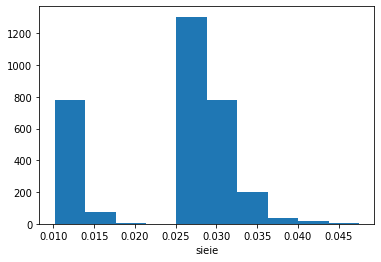

In [35]:
# - Sieie-> EB: 0.01015 EE: 0.0272  
plt.hist(ak.flatten(Photon_sieie_inv.sieie))
plt.xlabel('sieie')
plt.show()

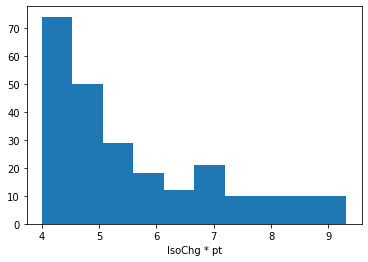

In [37]:
# - IsoChg-> EB: 1.141 EE: 1.051
plt.hist(ak.flatten(Photon_Isochg_inv.pfRelIso03_chg * Photon_Isochg_inv.pt))
plt.xlabel('IsoChg * pt')
plt.show()

### Test 3dim hist 

In [27]:
len(Photon[:,0])

36

In [28]:
ak.max(Photon[:,0].pt)

172.53145

In [29]:
ak.max(Photon[:,0].eta)

2.4667969

In [30]:
ak.max(Photon[:,0].sieie)

0.036834717

In [31]:
def make_bins(pt,eta,sieie,bin_range_str):

        bin_dict = {'PT_1_eta_1' : ( pt > 20 ) & ( pt < 30 ) & ( eta < 1) 
        ,'PT_1_eta_2' : ( pt > 20 ) & ( pt < 30 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_1_eta_3' : ( pt > 20 ) & ( pt < 30 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_1_eta_4' : ( pt > 20 ) & ( pt < 30 ) & ( eta > 2) & ( eta < 2.5 )

        ,'PT_2_eta_1' : ( pt > 30 ) & ( pt < 40 ) & ( eta < 1) 
        ,'PT_2_eta_2' : ( pt > 30 ) & ( pt < 40 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_2_eta_3' : ( pt > 30 ) & ( pt < 40 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_2_eta_4' : ( pt > 30 ) & ( pt < 40 ) & ( eta > 2) & ( eta < 2.5 )

        ,'PT_3_eta_1' : ( pt > 40 ) & ( pt < 50 ) & ( eta < 1) 
        ,'PT_3_eta_2' : ( pt > 40 ) & ( pt < 50 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_3_eta_3' : ( pt > 40 ) & ( pt < 50 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_3_eta_4' : ( pt > 40 ) & ( pt < 50 ) & ( eta > 2) & ( eta < 2.5 )

        ,'PT_4_eta_1' :  ( pt > 50 ) & ( eta < 1) 
        ,'PT_4_eta_2' :  ( pt > 50 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_4_eta_3' :  ( pt > 50 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_4_eta_4' :  ( pt > 50 ) & ( eta > 2) & ( eta < 2.5 )
        }
    
        binmask = bin_dict[bin_range_str]
        
        return ak.to_numpy(sieie[binmask])

In [32]:
photon = Photon[:,0]

In [33]:
photon

<PhotonArray [Photon, Photon, ... Photon, Photon] type='36 * photon'>

In [34]:
bin_name_list = ['PT_1_eta_1' ,'PT_1_eta_2' ,'PT_1_eta_3' ,'PT_1_eta_4' 
                 ,'PT_2_eta_1' ,'PT_2_eta_2' ,'PT_2_eta_3' ,'PT_2_eta_4' ,'PT_3_eta_1' ,'PT_3_eta_2' 
                 ,'PT_3_eta_3' ,'PT_3_eta_4' ,'PT_4_eta_1' ,'PT_4_eta_2' ,'PT_4_eta_3' ,'PT_4_eta_4']

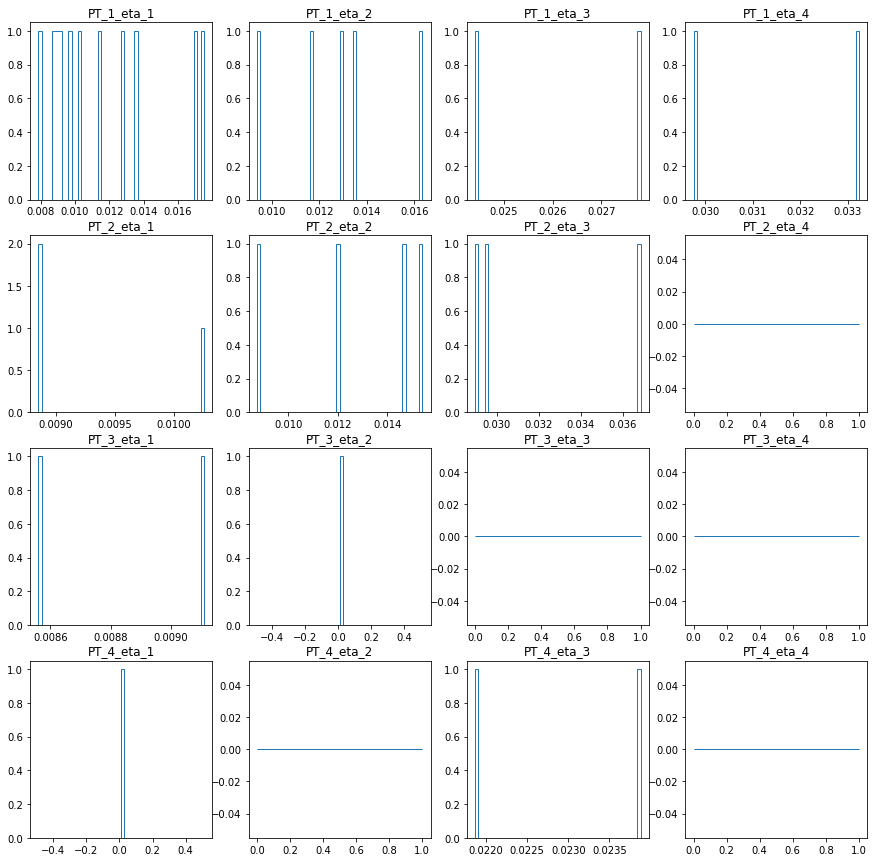

In [35]:
fig,axs = plt.subplots(4,4,figsize=(15,15))
axs = axs.ravel()

for ith,name in enumerate(bin_name_list):
    
    axs[ith].hist(make_bins(photon.pt,abs(photon.eta),photon.sieie,name),bins=50,histtype='step')
    axs[ith].set_title(name)

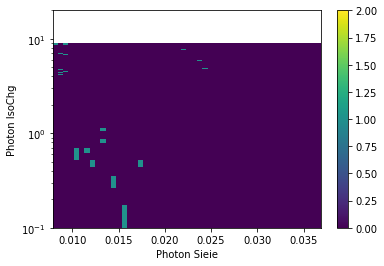

In [49]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()

sieie = ak.to_numpy(ak.flatten(Photon.sieie))
Isochg = ak.to_numpy(ak.flatten(Photon.pfRelIso03_chg * Photon.pt))


h = ax.hist2d(sieie,Isochg,bins=(50,100))
plt.xlabel('Photon Sieie')
plt.ylim(0.1,20)
plt.yscale('log')
plt.ylabel('Photon IsoChg')
fig.colorbar(h[3],ax=ax)
plt.show()

---

In [54]:
leading_pho = Photon[:,0]

### 5. Event Selection

In [57]:
##-----------  Cut flow5 and 6: Event Selection

# Z mass window
zmass_window_mask = ak.firsts((Diele.p4.mass) > 4)

# PT mask
Elept_mask = ak.firsts((Diele.lep1.pt >= 25) & (Diele.lep2.pt >=10))

# MET mask
MET_mask = MET.pt > 2


# Event selection mask
Event_sel_mask   = zmass_window_mask & Elept_mask & MET_mask


# Apply cuts
Diele_sel   = Diele[Event_sel_mask]
leading_pho_sel   = leading_pho[Event_sel_mask]
# Photon  EE and EB

isEE_mask = leading_pho.isScEtaEE
isEB_mask = leading_pho.isScEtaEB
Pho_EE = leading_pho[isEE_mask & Event_sel_mask]
Pho_EB = leading_pho[isEB_mask & Event_sel_mask]
MET_sel           = MET[Event_sel_mask]

In [58]:
print("#### 5. Event selection: {0}".format(len(Diele_sel)))

#### 5. Event selection: 36


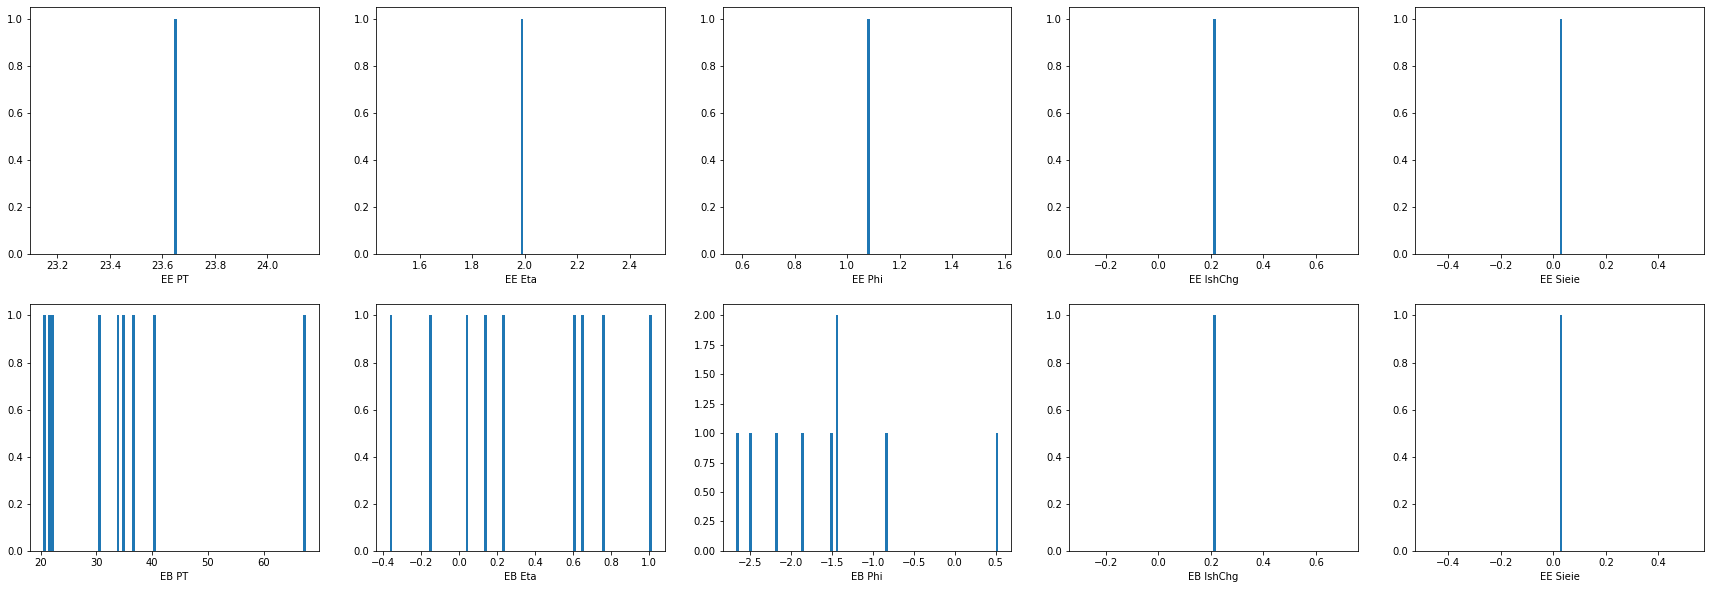

In [35]:
Pho_EE_pt     = flat_dim(Pho_EE.pt)
Pho_EE_eta    = flat_dim(Pho_EE.eta)
Pho_EE_phi    = flat_dim(Pho_EE.phi)
Pho_EE_Isochg = flat_dim(Pho_EE.pfRelIso03_chg)
Pho_EE_Sieie  = flat_dim(Pho_EE.sieie)


Pho_EB_pt  = flat_dim(Pho_EB.pt)
Pho_EB_eta = flat_dim(Pho_EB.eta)
Pho_EB_phi = flat_dim(Pho_EB.phi)
Pho_EB_Isochg = flat_dim(Pho_EE.pfRelIso03_chg)
Pho_EB_Sieie  = flat_dim(Pho_EE.sieie)


Diele_mass = flat_dim(Diele_sel.p4.mass)
eeg_vec = Diele_sel.p4 + leading_pho_sel
eeg_mass = flat_dim(eeg_vec.mass)

Ele1_pt  = flat_dim(Diele_sel.lep1.pt)
Ele1_eta = flat_dim(Diele_sel.lep1.eta)
Ele1_phi = flat_dim(Diele_sel.lep1.phi)

Ele2_pt  = flat_dim(Diele_sel.lep2.pt)
Ele2_eta = flat_dim(Diele_sel.lep2.eta)
Ele2_phi = flat_dim(Diele_sel.lep2.phi)
fig,axs = plt.subplots(2,5,figsize=(30,10))
bins=100

axs[0,0].hist(Pho_EE_pt,bins=bins)
axs[0,0].set_xlabel('EE PT')
axs[0,1].hist(Pho_EE_eta,bins=bins)
axs[0,1].set_xlabel('EE Eta')
axs[0,2].hist(Pho_EE_phi,bins=bins)
axs[0,2].set_xlabel('EE Phi')
axs[0,3].hist(Pho_EE_Isochg,bins=bins)
axs[0,3].set_xlabel('EE IshChg')
axs[0,4].hist(Pho_EE_Sieie,bins=bins)
axs[0,4].set_xlabel('EE Sieie')

axs[1,0].hist(Pho_EB_pt,bins=bins)
axs[1,0].set_xlabel('EB PT')
axs[1,1].hist(Pho_EB_eta,bins=bins)
axs[1,1].set_xlabel('EB Eta')
axs[1,2].hist(Pho_EB_phi,bins=bins)
axs[1,2].set_xlabel('EB Phi')
axs[1,3].hist(Pho_EB_Isochg,bins=bins)
axs[1,3].set_xlabel('EB IshChg')
axs[1,4].hist(Pho_EB_Sieie,bins=bins)
axs[1,4].set_xlabel('EE Sieie')
plt.show()

In [36]:
leading_ele, subleading_ele = ak.flatten(TLorentz_vector_cylinder(Diele_sel.lep1)),ak.flatten(TLorentz_vector_cylinder(Diele_sel.lep2))

dR_e1pho  = flat_dim(leading_ele.delta_r(leading_pho_sel)) # dR pho,ele1
dR_e2pho  = flat_dim(subleading_ele.delta_r(leading_pho_sel)) # dR pho,ele2

In [37]:
Diele_mass = flat_dim(Diele_sel.p4.mass)
eeg_mass = flat_dim(eeg_vec.mass)
dR_e1pho  = flat_dim(leading_ele.delta_r(leading_pho_sel)) # dR pho,ele1
dR_e2pho  = flat_dim(subleading_ele.delta_r(leading_pho_sel)) 

Ele1_pt  = flat_dim(Diele_sel.lep1.pt)
Ele1_eta = flat_dim(Diele_sel.lep1.eta)
Ele1_phi = flat_dim(Diele_sel.lep1.phi)

Ele2_pt  = flat_dim(Diele_sel.lep2.pt)
Ele2_eta = flat_dim(Diele_sel.lep2.eta)
Ele2_phi = flat_dim(Diele_sel.lep2.phi)

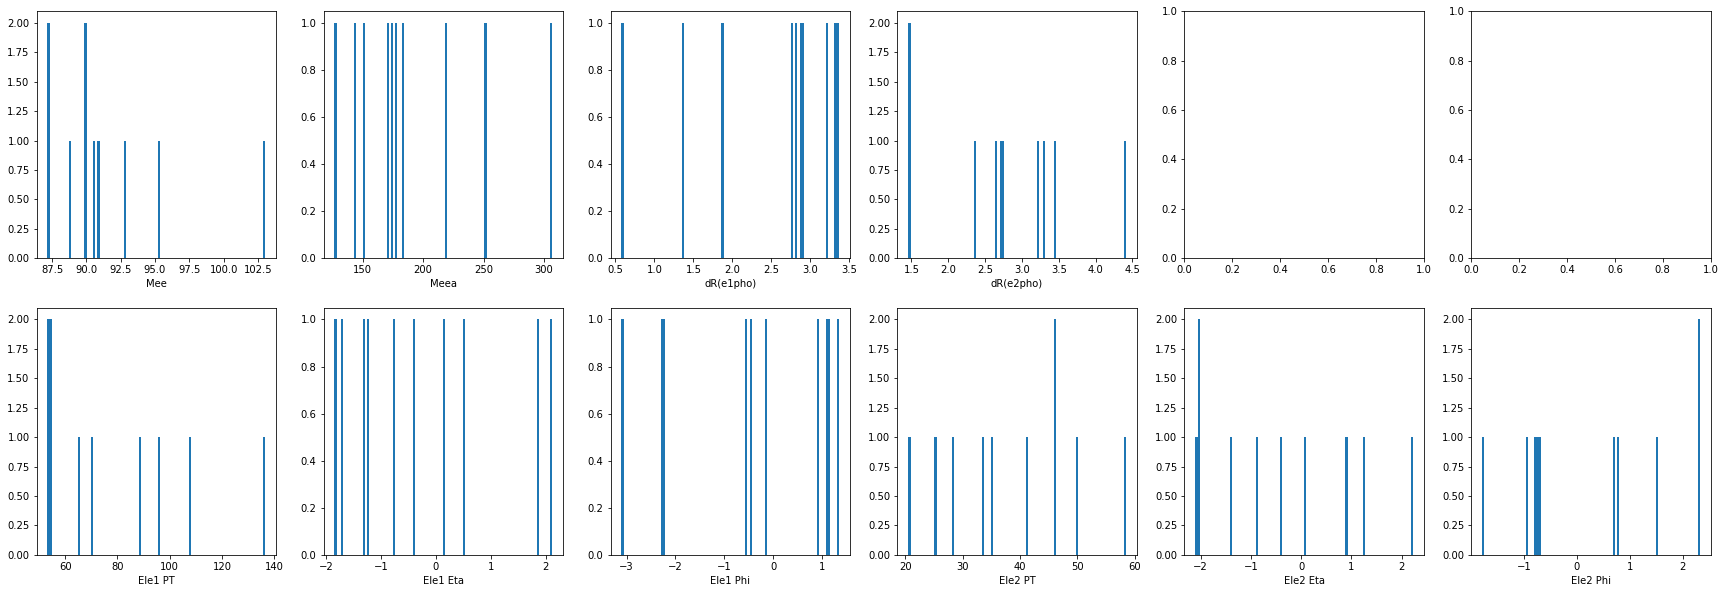

In [38]:
fig,axs = plt.subplots(2,6,figsize=(30,10))
bins=100

axs[0,0].hist(Diele_mass,bins=bins)
axs[0,0].set_xlabel('Mee')
axs[0,1].hist(eeg_mass,bins=bins)
axs[0,1].set_xlabel('Meea')
axs[0,2].hist(dR_e1pho,bins=bins)
axs[0,2].set_xlabel('dR(e1pho)')
axs[0,3].hist(dR_e2pho,bins=bins)
axs[0,3].set_xlabel('dR(e2pho)')


axs[1,0].hist(Ele1_pt,bins=bins)
axs[1,0].set_xlabel('Ele1 PT')

axs[1,1].hist(Ele1_eta,bins=bins)
axs[1,1].set_xlabel('Ele1 Eta')

axs[1,2].hist(Ele1_phi,bins=bins)
axs[1,2].set_xlabel('Ele1 Phi')

axs[1,3].hist(Ele2_pt,bins=bins)
axs[1,3].set_xlabel('Ele2 PT')

axs[1,4].hist(Ele2_eta,bins=bins)
axs[1,4].set_xlabel('Ele2 Eta')

axs[1,5].hist(Ele2_phi,bins=bins)
axs[1,5].set_xlabel('Ele2 Phi')

plt.show()